## This notebook holds a data analysis
The aim of the notebook is: 
1. Get some scatterplots from PC1 and PC2
2. Analyze PC1 and the principal component distribution, what are the loading distribution
3. Look at MSE vs SAM for clustering. Can we distinguish between light/dark clusters and material based clusters?

In [2]:
import torch
import glob
import numpy as np
import matplotlib.pyplot as plt
from hypso import Hypso
from utils import calculate_rmse, calculate_sam
import os
from sklearn.decomposition import PCA
from MFA import MFA
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize


data_dir = glob.glob('data/linearity_test/*.nc')
print(f"Found {len(data_dir)} files.")

Found 49 files.


In [3]:
target_total_samples = 30000
samples_per_file = target_total_samples // len(data_dir) 
sampled_data_list = []

print(f"Aiming to extract ~{samples_per_file} pixels per file.")

for file in data_dir:
    # Load Data
    try:
        satobj = Hypso(file) 
        if satobj is None: continue
        
        # Load and reshape
        data = satobj.l1a_cube.values.astype(np.float32)
        h, w, b = data.shape
        data_2d = data.reshape(-1, b) # Shape: (Total_Pixels_In_Image, 120)
        
        # Random Subsampling 
        total_pixels_in_image = data_2d.shape[0]
        
        # Determine how many to take (don't take more than exists)
        n_to_take = min(samples_per_file, total_pixels_in_image)
        
        # Generate random indices
        rng = np.random.default_rng()
        indices = rng.choice(total_pixels_in_image, size=n_to_take, replace=False)
        
        # Grab the random pixels and add to list
        sampled_pixel_subset = data_2d[indices, :]
        sampled_data_list.append(sampled_pixel_subset)
        
        print(f"File: {os.path.basename(file)} | Extracted {n_to_take} pixels.")

    except Exception as e:
        print(f"Error processing {file}: {e}")

# Final Concatenation
if sampled_data_list:
    final_dataset = np.concatenate(sampled_data_list, axis=0)
    print("-" * 30)
    print(f"Final Analysis Dataset Shape: {final_dataset.shape}")
else:
    print("No data loaded.")

Aiming to extract ~612 pixels per file.
File: aeronetgalata_2025-01-02T08-18-16Z-l1a.nc | Extracted 612 pixels.
File: algeria_2022-10-29T09-44-03Z-l1a.nc | Extracted 612 pixels.
File: amazonia_2024-09-21T13-12-47Z-l1a.nc | Extracted 612 pixels.
File: annapolis_2025-08-04T15-25-40Z-l1a.nc | Extracted 612 pixels.
File: antarctica_2022-11-20T08-44-35Z-l1a.nc | Extracted 612 pixels.
File: barfire_2025-08-04T09-11-36Z-l1a.nc | Extracted 612 pixels.
File: bermuda_2024-07-16T14-27-21Z-l1a.nc | Extracted 612 pixels.
File: blacksea2_2024-07-21T07-40-44Z-l1a.nc | Extracted 612 pixels.
File: capedyer_2023-10-16T14-54-55Z-l1a.nc | Extracted 612 pixels.
File: capescott_2023-05-09T19-29-59Z-l1a.nc | Extracted 612 pixels.
File: caspiansea1_2024-08-22T07-05-53Z-l1a.nc | Extracted 612 pixels.
File: caspiansea3_2024-07-12T06-35-24Z-l1a.nc | Extracted 612 pixels.
File: el-tabitano_2022-12-15T14-19-33Z-l1a.nc | Extracted 612 pixels.
File: erie_2023-11-23T16-03-05Z-l1a.nc | Extracted 612 pixels.
File: erie

### Making a PCA model, this because I will use it to look at the scatterplots

In [4]:
# Calculate Mean
mean_spectrum = np.mean(final_dataset, axis=0)

# Make the PCA Model
pca = PCA() 

# Fit the model to your data
pca.fit(final_dataset)

,"n_components n_components: int, float or 'mle', default=NoneNumber of components to keep.if n_components is not set all components are kept:: n_components == min(n_samples, n_features)If ``n_components == 'mle'`` and ``svd_solver == 'full'``, Minka'sMLE is used to guess the dimension. Use of ``n_components == 'mle'``will interpret ``svd_solver == 'auto'`` as ``svd_solver == 'full'``.If ``0 < n_components < 1`` and ``svd_solver == 'full'``, select thenumber of components such that the amount of variance that needs to beexplained is greater than the percentage specified by n_components.If ``svd_solver == 'arpack'``, the number of components must bestrictly less than the minimum of n_features and n_samples.Hence, the None case results in:: n_components == min(n_samples, n_features) - 1",None
,"copy copy: bool, default=TrueIf False, data passed to fit are overwritten and runningfit(X).transform(X) will not yield the expected results,use fit_transform(X) instead.",True
,"whiten whiten: bool, default=FalseWhen True (False by default) the `components_` vectors are multipliedby the square root of n_samples and then divided by the singular valuesto ensure uncorrelated outputs with unit component-wise variances.Whitening will remove some information from the transformed signal(the relative variance scales of the components) but can sometimeimprove the predictive accuracy of the downstream estimators bymaking their data respect some hard-wired assumptions.",False
,"svd_solver svd_solver: {'auto', 'full', 'covariance_eigh', 'arpack', 'randomized'}, default='auto'""auto"" : The solver is selected by a default 'auto' policy is based on `X.shape` and `n_components`: if the input data has fewer than 1000 features and more than 10 times as many samples, then the ""covariance_eigh"" solver is used. Otherwise, if the input data is larger than 500x500 and the number of components to extract is lower than 80% of the smallest dimension of the data, then the more efficient ""randomized"" method is selected. Otherwise the exact ""full"" SVD is computed and optionally truncated afterwards.""full"" : Run exact full SVD calling the standard LAPACK solver via `scipy.linalg.svd` and select the components by postprocessing""covariance_eigh"" : Precompute the covariance matrix (on centered data), run a classical eigenvalue decomposition on the covariance matrix typically using LAPACK and select the components by postprocessing. This solver is very efficient for n_samples >> n_features and small n_features. It is, however, not tractable otherwise for large n_features (large memory footprint required to materialize the covariance matrix). Also note that compared to the ""full"" solver, this solver effectively doubles the condition number and is therefore less numerical stable (e.g. on input data with a large range of singular values).""arpack"" : Run SVD truncated to `n_components` calling ARPACK solver via `scipy.sparse.linalg.svds`. It requires strictly `0 < n_components < min(X.shape)`""randomized"" : Run randomized SVD by the method of Halko et al... versionadded:: 0.18.0.. versionchanged:: 1.5 Added the 'covariance_eigh' solver.",'auto'
,"tol tol: float, default=0.0Tolerance for singular values computed by svd_solver == 'arpack'.Must be of range [0.0, infinity)... versionadded:: 0.18.0",0.0
,"iterated_power iterated_power: int or 'auto', default='auto'Number of iterations for the power method computed bysvd_solver == 'randomized'.Must be of range [0, infinity)... versionadded:: 0.18.0",'auto'
,"n_oversamples n_oversamples: int, default=10This parameter is only relevant when `svd_solver=""randomized""`.It corresponds to the additional number of random vectors to sample therange of `X` so as to ensure proper conditioning. See:func:`~sklearn.utils.extmath.randomized_svd` for more details... versionadded:: 1.1",10
,"power_iteration_normalizer power_iteration_normalizer: {'auto', 'QR', 'LU', 'none'}, default='auto'Power iteration normalizer for randomized S

making scatterplots from PC1 vs PC2 etc.

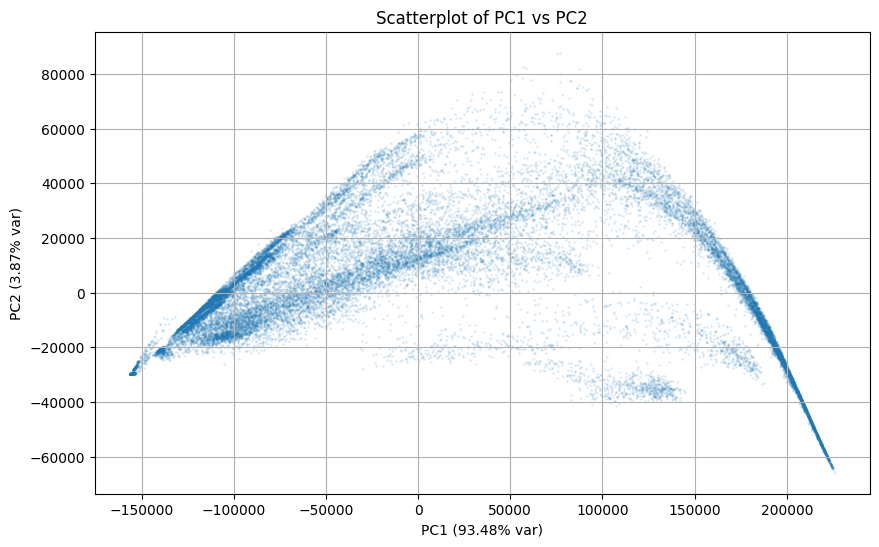

In [5]:
# Transform the data into the PCA space
pca_transformed = pca.transform(final_dataset)

# Plot PC1 vs PC2
plt.figure(figsize=(10, 6))
plt.scatter(pca_transformed[:, 0], pca_transformed[:, 1], alpha=0.1, s=1)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% var)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% var)')
plt.title('Scatterplot of PC1 vs PC2')
plt.grid(True)
plt.show()

PC1 distribution

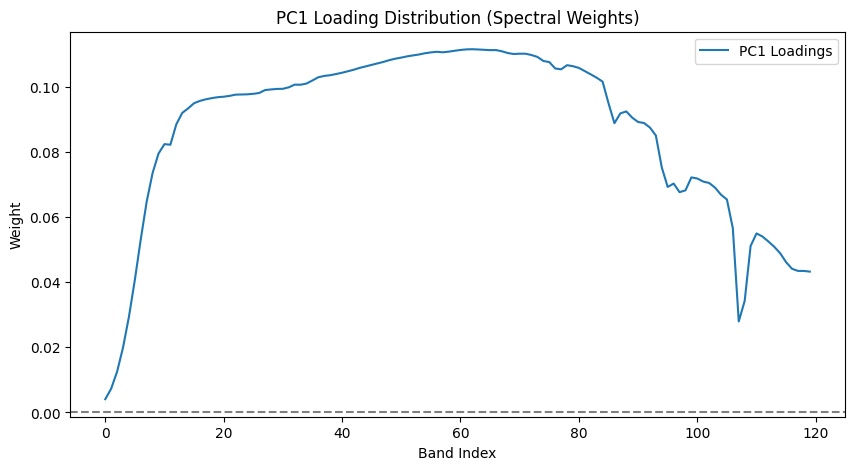

Explained variance of PC1: 93.48%


In [6]:
# Get loadings for PC1
pc1_loadings = pca.components_[0]

plt.figure(figsize=(10, 5))
plt.plot(pc1_loadings, label='PC1 Loadings')
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.title('PC1 Loading Distribution (Spectral Weights)')
plt.xlabel('Band Index')
plt.ylabel('Weight')
plt.legend()
plt.show()

# Print explained variance to see how dominant PC1 is
print(f"Explained variance of PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")

3. MSE vs. SAM for Clustering

In [10]:
import torch
from tqdm import tqdm # Useful for tracking progress

# 1. Run KMeans
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto').fit(final_dataset)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# 2. Analyze Clusters
print(f"{'Cluster':<10} | {'Size':<10} | {'Avg RMSE':<12} | {'Avg SAM':<12}")
print("-" * 55)

for i in range(n_clusters):
    cluster_indices = np.where(labels == i)[0]
    cluster_pixels = final_dataset[cluster_indices]
    center = centers[i]
    
    # Convert numpy data to torch tensors for your utils.py functions
    # Adding [None, :] to ensure they have the (1, B) shape expected by dim=1
    center_tensor = torch.tensor(center, dtype=torch.float32).unsqueeze(0)
    
    rmse_list = []
    sam_list = []
    
    # Iterate through pixels (or a subset to save time)
    for p in cluster_pixels:
        p_tensor = torch.tensor(p, dtype=torch.float32).unsqueeze(0)
        
        # Now these calls to your utils.py will work
        rmse_list.append(calculate_rmse(p_tensor, center_tensor))
        sam_list.append(calculate_sam(p_tensor, center_tensor))
    
    avg_rmse = np.mean(rmse_list)
    avg_sam = np.mean(sam_list)
    
    print(f"{i:<10} | {len(cluster_pixels):<10} | {avg_rmse:<12.4f} | {avg_sam:<12.4f}")

Cluster    | Size       | Avg RMSE     | Avg SAM     
-------------------------------------------------------
0          | 7729       | 1446.7010    | 0.1375      
1          | 3654       | 2313.2981    | 0.0641      
2          | 4151       | 2657.6888    | 0.1278      
3          | 3600       | 3481.1309    | 0.1062      
4          | 5120       | 2101.3911    | 0.1426      
5          | 2635       | 3497.8603    | 0.1104      
6          | 3099       | 829.4004     | 0.4812      


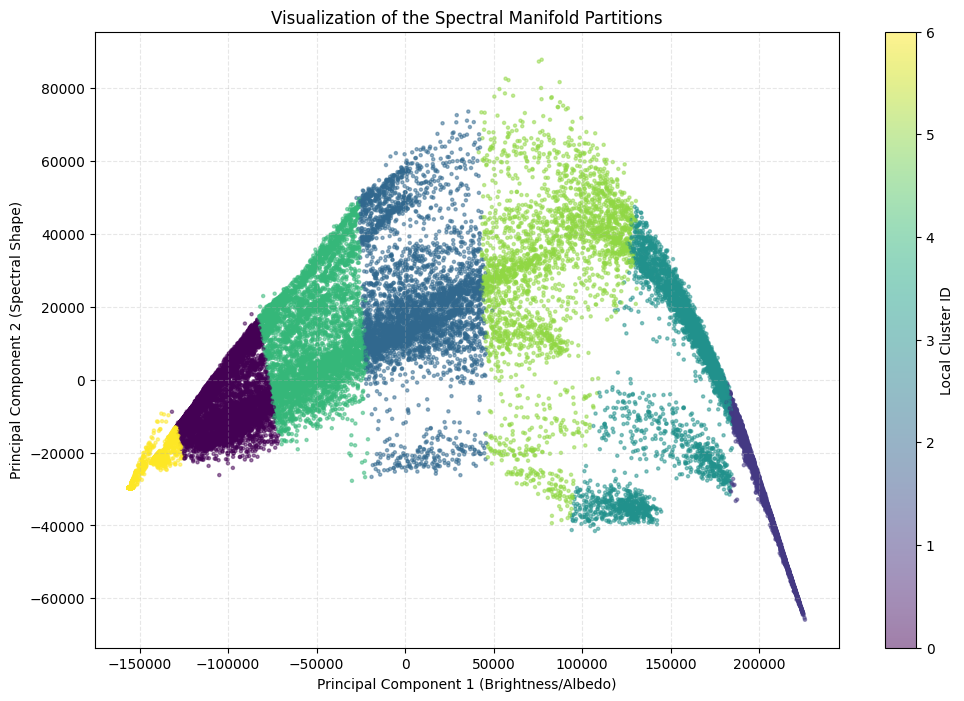

In [11]:
# 1. Generate the scatterplot
plt.figure(figsize=(12, 8))

# We use the labels from your KMeans fitting (kmeans.labels_)
# 'c=labels' handles the color coding, and 'cmap' defines the palette
scatter = plt.scatter(pca_transformed[:, 0], 
                      pca_transformed[:, 1], 
                      c=labels, 
                      cmap='viridis', 
                      alpha=0.5, 
                      s=5)

# 2. Add the Colorbar to show Cluster IDs
cbar = plt.colorbar(scatter)
cbar.set_label('Local Cluster ID')

# 3. Add Labels and Title
plt.xlabel('Principal Component 1 (Brightness/Albedo)')
plt.ylabel('Principal Component 2 (Spectral Shape)')
plt.title('Visualization of the Spectral Manifold Partitions')

# 4. Add a light grid for better readability
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()

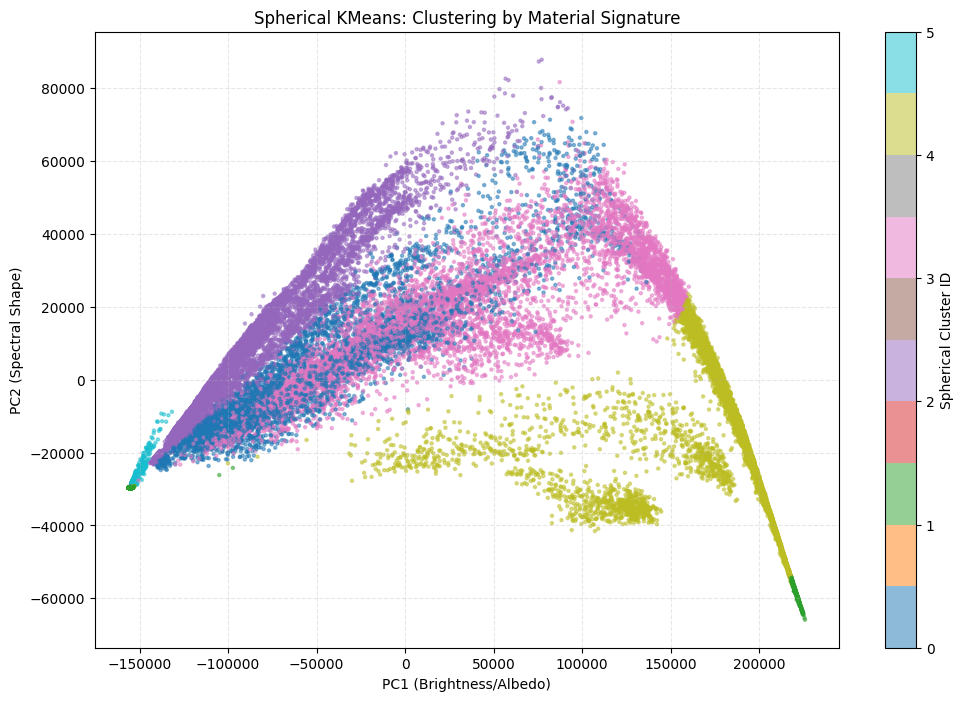

In [12]:
from sklearn.preprocessing import normalize

# 1. Normalize the data: This removes the 'Brightness' component
# final_dataset: (N_samples, N_bands)
data_normalized = normalize(final_dataset, norm='l2')

# 2. Run KMeans on the normalized data
n_clusters = 6
skmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
skmeans_labels = skmeans.fit_predict(data_normalized)

# 3. Plotting
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_transformed[:, 0], pca_transformed[:, 1], 
                      c=skmeans_labels, cmap='tab10', alpha=0.5, s=5)
cbar = plt.colorbar(scatter)
cbar.set_label('Spherical Cluster ID')
plt.xlabel('PC1 (Brightness/Albedo)')
plt.ylabel('PC2 (Spectral Shape)')
plt.title('Spherical KMeans: Clustering by Material Signature')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

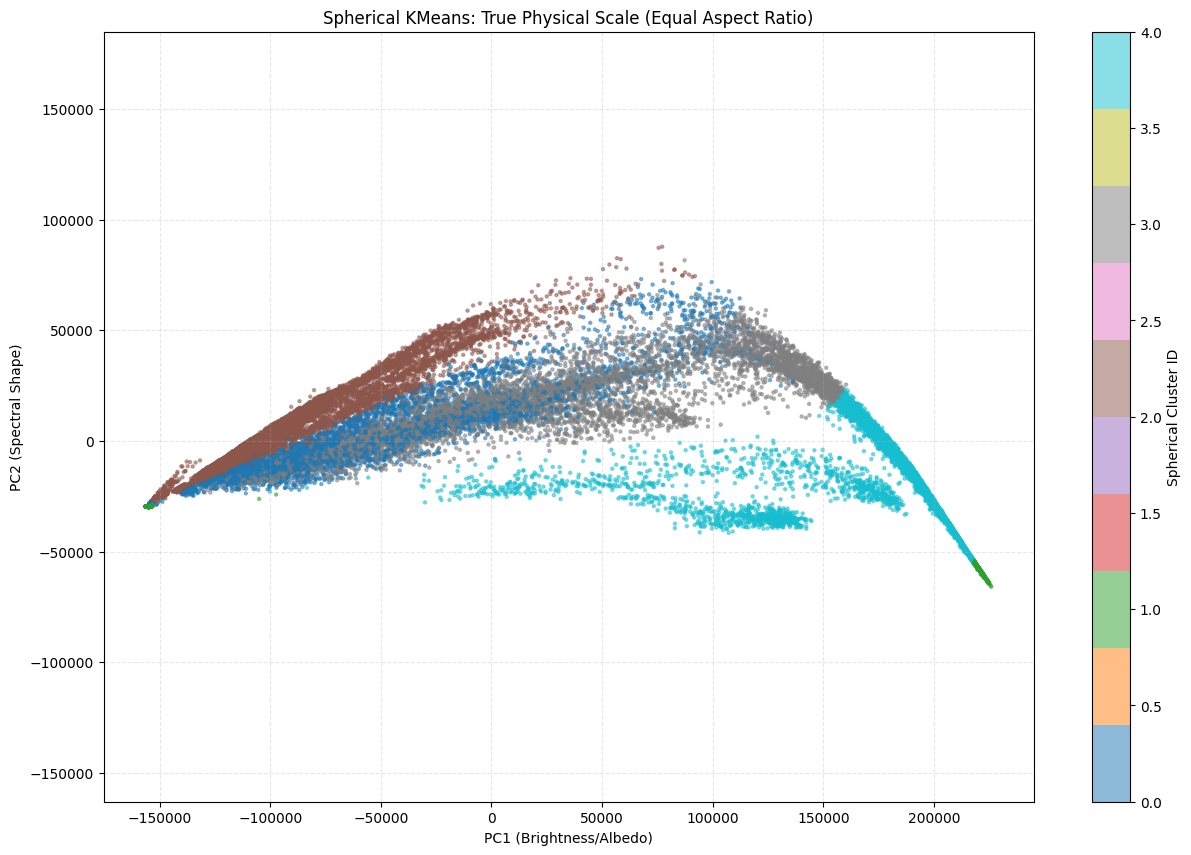

In [20]:
from sklearn.preprocessing import normalize

# 1. Normalize the data: This removes the 'Brightness' component
data_normalized = normalize(final_dataset, norm='l2')

# 2. Run KMeans on the normalized data
n_clusters = 5
skmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
skmeans_labels = skmeans.fit_predict(data_normalized)

# 3. Plotting with Equal Scaling
plt.figure(figsize=(15, 10))
scatter = plt.scatter(pca_transformed[:, 0], pca_transformed[:, 1], 
                      c=skmeans_labels, cmap='tab10', alpha=0.5, s=5)

# --- THE KEY ADDITION ---
plt.axis('equal') 
# ------------------------

cbar = plt.colorbar(scatter)
cbar.set_label('Spherical Cluster ID')
plt.xlabel('PC1 (Brightness/Albedo)')
plt.ylabel('PC2 (Spectral Shape)')
plt.title('Spherical KMeans: True Physical Scale (Equal Aspect Ratio)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

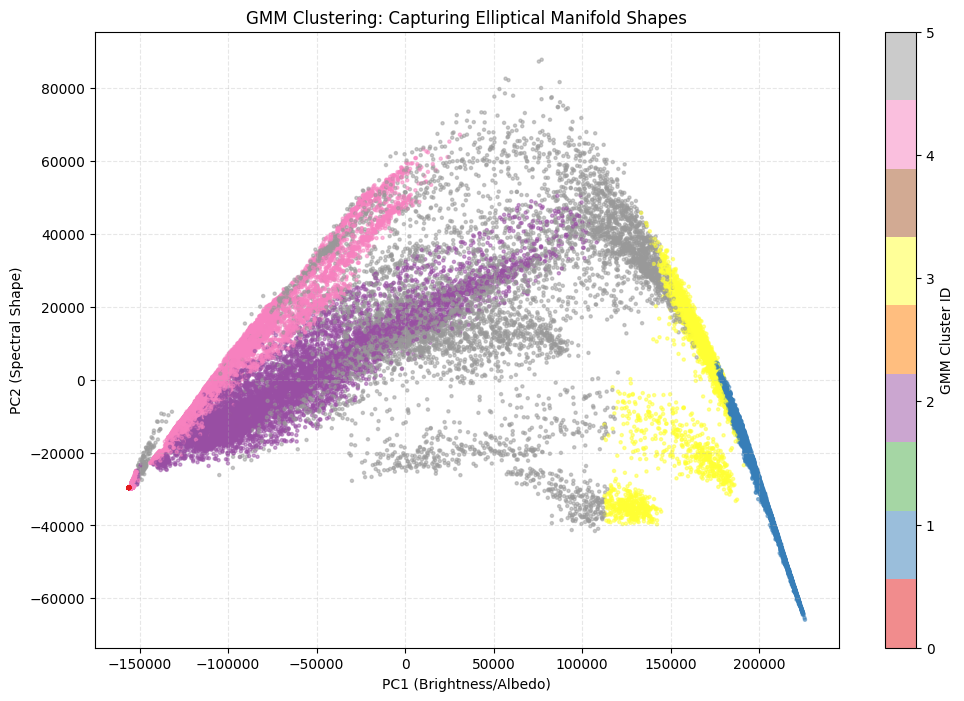

In [13]:
from sklearn.mixture import GaussianMixture

# 1. Fit GMM on the first few Principal Components
# Using the PCs directly often yields cleaner results for GMM
n_components = 6
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm_labels = gmm.fit_predict(pca_transformed[:, :5]) # Using first 5 PCs

# 2. Plotting
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_transformed[:, 0], pca_transformed[:, 1], 
                      c=gmm_labels, cmap='Set1', alpha=0.5, s=5)
cbar = plt.colorbar(scatter)
cbar.set_label('GMM Cluster ID')
plt.xlabel('PC1 (Brightness/Albedo)')
plt.ylabel('PC2 (Spectral Shape)')
plt.title('GMM Clustering: Capturing Elliptical Manifold Shapes')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

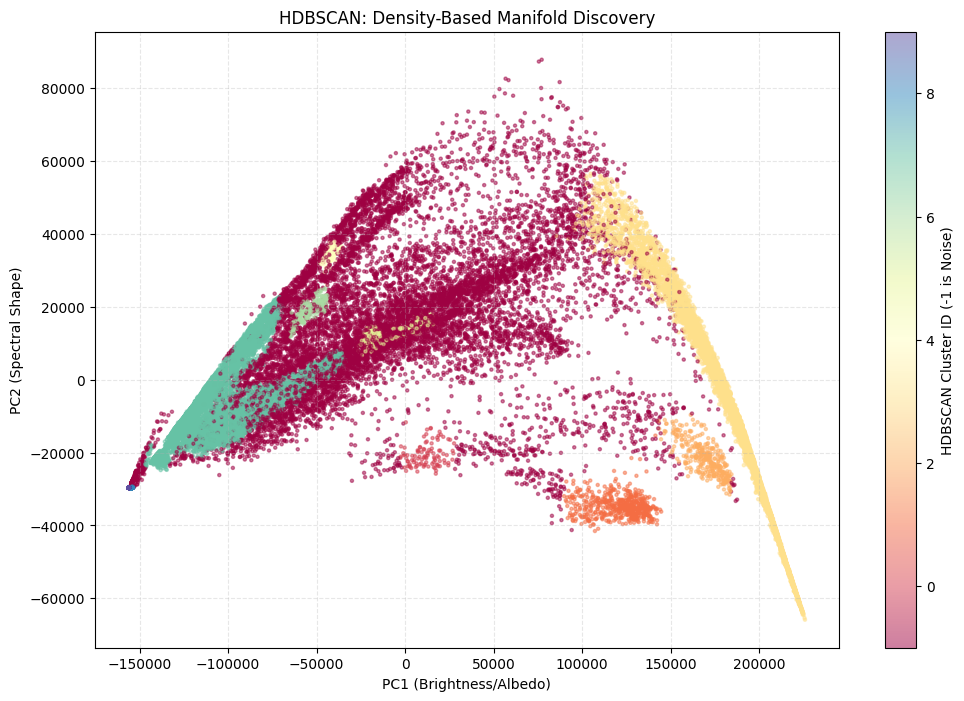

In [15]:
import hdbscan

# 1. Run HDBSCAN
# min_cluster_size: smallest number of points to be considered a cluster
clusterer = hdbscan.HDBSCAN(min_cluster_size=100, gen_min_span_tree=True)
hdbscan_labels = clusterer.fit_predict(pca_transformed[:, :3])

# 2. Plotting
plt.figure(figsize=(12, 8))
# We use a custom color map where -1 (noise) is grey
scatter = plt.scatter(pca_transformed[:, 0], pca_transformed[:, 1], 
                      c=hdbscan_labels, cmap='Spectral', alpha=0.5, s=5)
cbar = plt.colorbar(scatter)
cbar.set_label('HDBSCAN Cluster ID (-1 is Noise)')
plt.xlabel('PC1 (Brightness/Albedo)')
plt.ylabel('PC2 (Spectral Shape)')
plt.title('HDBSCAN: Density-Based Manifold Discovery')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()